## K Nearest Neighbours

El K-NN es un algoritmo de aprendizaje supervisado que se identifica con los **métodos de clasificación vagos**(*lazy learning methods*). Este tipo de algoritmos no genera un modelo de clasificación en la etapa de entrenamiento. Durante esta etapa se limita a almacenar todos los datos. El aprendizaje para la clasificación se produce en el mismo momento en el que se prueban los datos del set de testeo.

Esto trae consigo varias consecuencias. El tiempo de entrenamiento es muy rápido, no obstante, son generalmente mucho más lentos de evaluar. Otro detalle a tener en cuenta es el espacio en memoria y recursos que se requieren para almacenar las instancias del set de entrenamiento.

K-NN trata de clasificar una nueva instancia en base a la votación de una serie de puntos cercanos, los vecinos. El parámetro **k** nos permite determinar cuantos vecinos se tendran en cuenta en la votación y, para escoger los vecinos se determina métrica para medir la distancia entre los puntos. Un ejemplo es la distancia euclídea:

$$d_E(P,Q)=\sqrt{(p_1 - q_1)^2 + (p_2 - q_2)^2 + ... + (p_n - q_n)^2}$$

## Datos

La base de datos que vamos a utilizar es la famosa  **MNIST database**. Esta base de datos esta formada por un conjunto de imagenes normalizadas (28x28) de dígitos escritos a mano. Puede accederse a ella a través del siguiente enlace: http://yann.lecun.com/exdb/mnist/ 






In [1]:
from sklearn.datasets import fetch_openml
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
sns.set_style('dark')
%matplotlib inline




In [2]:
mnist = fetch_openml('mnist_784', version=1, cache=True)
mnist_data=mnist.data.astype(np.int16)
mnist_label=mnist.target.astype(np.int8)
columns=mnist.feature_names

In [3]:
mnist_data_pd=pd.DataFrame(mnist_data, columns=columns)
mnist_labels_pd=pd.Series(mnist_label, name='labels')

In [4]:
X_train, X_test, y_train, y_test=train_test_split(mnist_data_pd, mnist_labels_pd, random_state=42, test_size=0.3)

In [5]:
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((49000, 784), (21000, 784), (49000,), (21000,))

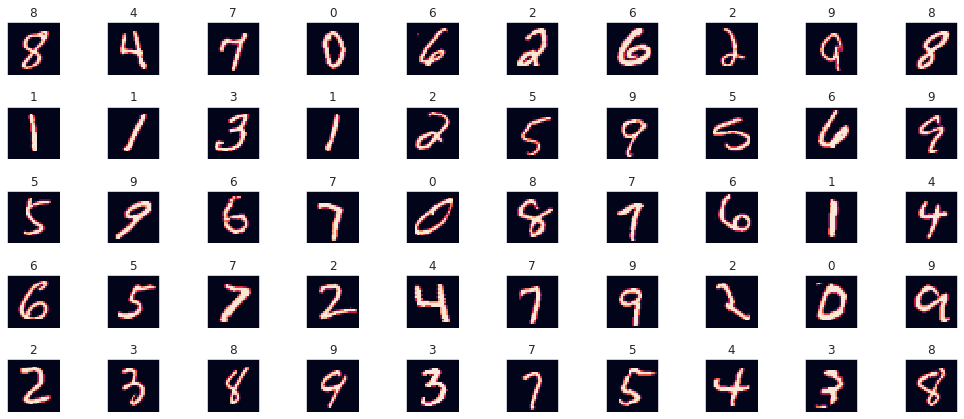

In [6]:
figure, ax=plt.subplots(5,10, figsize=(14,6))
plt.tight_layout()
for row in range(5):
    for col in range(10):
        num=np.random.randint(len(X_train))
        ax[row, col].imshow(X_train.iloc[num].values.reshape((28,28)))
        ax[row, col].tick_params(labelleft=False,labelbottom=False)
        ax[row,col].set_title(y_train.iloc[num])
            

Ahora que hemos cargado las imagenes y hemos visualizado algunos ejemplos del set de entrenamiento con sus respectivas etiquetas, vamos a definir las funciones que vamos a utilizar para realizar el *data augmentation* del mismo.

Las siguientes funciones reciben un *numpy array* de dimensiones (28,28) y lo desplazan un pixel en el sentido correspondiente (arriba, abajo, izquierda y derecha).

Con esto conseguimos multiplicar el tamaño del set de entrenamiento 5 veces.

In [7]:
def shift_right(image):
    aux_image=np.copy(image)
    for row in range(len(image)):
        for col in range(len(image)-1):
            aux_image[row, -(col+1)]=aux_image[row, -(col+2)]
    return aux_image

def shift_left(image):
    aux_image=np.copy(image)
    for row in range(len(image)):
        for col in range(len(image)-1):
            aux_image[row, col]=aux_image[row, col+1]
    return aux_image

def shift_down(image):
    aux_image=np.copy(image)
    for row in range(len(image)-1):
            aux_image[-(row+1),:]=aux_image[-(row+2),:]
    return aux_image

def shift_up(image):
    aux_image=np.copy(image)
    for row in range(len(image)-1):
            aux_image[row,:]=aux_image[row+1,:]
    return aux_image

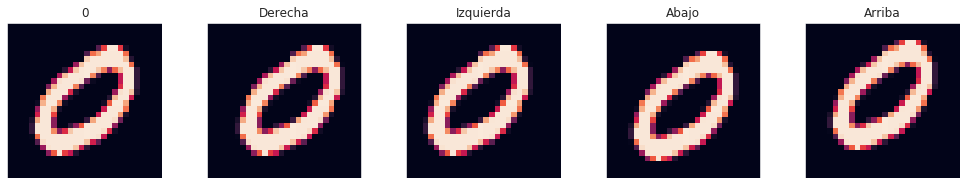

In [8]:
figure, ax=plt.subplots(1,5, figsize=(14,6))
plt.tight_layout()
ax[0].imshow(X_train.iloc[0].values.reshape((28,28)))
ax[0].tick_params(labelleft=False,labelbottom=False)
ax[0].set_title(y_train.iloc[0])
ax[1].imshow(shift_right(X_train.iloc[0].values.reshape((28,28))))
ax[1].tick_params(labelleft=False,labelbottom=False)
ax[1].set_title('Derecha')
ax[2].imshow(shift_left(X_train.iloc[0].values.reshape((28,28))))
ax[2].tick_params(labelleft=False,labelbottom=False)
ax[2].set_title('Izquierda')
ax[3].imshow(shift_down(X_train.iloc[0].values.reshape((28,28))))
ax[3].tick_params(labelleft=False,labelbottom=False)
ax[3].set_title('Abajo')
ax[4].imshow(shift_up(X_train.iloc[0].values.reshape((28,28))))
ax[4].tick_params(labelleft=False,labelbottom=False)
ax[4].set_title('Arriba');

In [9]:
def augmentate_data(data, labels):
    augmentated_data_list=[]
    augmentated_labels_list=[]
    for _ in range(len(data)):
        augmentated_data_list.append(shift_right(data.iloc[_].values.reshape(28,28)).flatten())
        augmentated_data_list.append(shift_left(data.iloc[_].values.reshape(28,28)).flatten())
        augmentated_data_list.append(shift_down(data.iloc[_].values.reshape(28,28)).flatten())
        augmentated_data_list.append(shift_up(data.iloc[_].values.reshape(28,28)).flatten())
        for n in range(0,4):
            augmentated_labels_list.append(labels.iloc[_])
    return(np.array(augmentated_data_list), np.array(augmentated_labels_list))
    
            


In [10]:
new_data1, new_labels=augmentate_data(mnist_data_pd.iloc[:35000], mnist_labels_pd.iloc[:35000])


In [11]:
new_data2, new_labels2=augmentate_data(mnist_data_pd.iloc[35000:], mnist_labels_pd.iloc[35000:])


In [12]:
total_data=np.concatenate((mnist_data_pd.values,new_data1,new_data2), axis=0)
total_labels=np.concatenate((mnist_labels_pd.values,new_labels, new_labels2), axis=0)

In [13]:
total_data_pd=pd.DataFrame(total_data, columns=mnist_data_pd.columns)
total_labels_pd=pd.Series(total_labels, name='labels')

In [14]:
print(total_data_pd.shape, total_labels_pd.shape)

(350000, 784) (350000,)


Como habrás podido observar en las imágenes anteriores, la gran mayoria de píxeles de las imágenes, **no aportan ninguna infomación** de interés a la hora de clasificar, sin embargo, **incrementan** en gran medida el **coste computacional** necesario para realizar las predicciones.

Por este motivo, vamos a realizar una **reducción de dimensionalidad** a través de un análisis de componentes principales (PCA), preservando el 90% de varianza.

In [15]:
pca=PCA(n_components=0.90)
total_data_pd_reduced=pca.fit_transform(total_data_pd)

In [16]:
total_data_pd_reduced.shape

(350000, 91)

Podemos ver la increíble reducción del numero de columnas que tiene ahora nuestro set de entrenamiento.

Una vez tenemos preparados los datos, empezamos con el entrenamiento de nuestro modelo. 

Para ajustarlo vamos a utilizar una malla de validación cruzada (*GridSearchCV*), probando diferentes valores de número de vecinos (**k**) y pesos, utilizando la **distancia euclídea**: [ metric = minkowski, p = 2 ]

In [17]:
param_grid=[{'n_neighbors':[3,4,5], 'weights':['distance', 'uniform'], 'metric':['minkowski'], 'p':[2]}]

In [18]:
kneighborsclassifier=KNeighborsClassifier()
grid=GridSearchCV(kneighborsclassifier, param_grid=param_grid, cv=5, n_jobs=-1, scoring='accuracy')

In [19]:
grid.fit(X_train, y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
             estimator=KNeighborsClassifier(algorithm='auto', leaf_size=30,
                                            metric='minkowski',
                                            metric_params=None, n_jobs=None,
                                            n_neighbors=5, p=2,
                                            weights='uniform'),
             iid='warn', n_jobs=-1,
             param_grid=[{'metric': ['minkowski'], 'n_neighbors': [3, 4, 5],
                          'p': [2], 'weights': ['distance', 'uniform']}],
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

In [21]:
grid.cv_results_

{'mean_fit_time': array([20.47702432, 18.39758554, 16.89745679, 15.96780558, 16.87984715,
        12.661447  ]),
 'std_fit_time': array([0.92516503, 0.81129466, 0.95708222, 1.31249562, 2.14532886,
        1.30079324]),
 'mean_score_time': array([854.02824435, 826.53671584, 822.2369525 , 827.70378599,
        821.96751451, 732.73733854]),
 'std_score_time': array([ 13.22631246,   4.21346496,   1.26357424,   3.27031101,
          1.30188927, 108.97608839]),
 'param_metric': masked_array(data=['minkowski', 'minkowski', 'minkowski', 'minkowski',
                    'minkowski', 'minkowski'],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_neighbors': masked_array(data=[3, 3, 4, 4, 5, 5],
              mask=[False, False, False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_p': masked_array(data=[2, 2, 2, 2, 2, 2],
              mask=[False, False, False, False, False, False],
  

In [22]:
kneighborsclassifier=KNeighborsClassifier(**grid.best_params_)
kneighborsclassifier.fit(X_train, y_train)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=4, p=2,
                     weights='distance')

In [23]:
predictions=kneighborsclassifier.predict(X_test)

In [24]:
print(classification_report(y_test, predictions))

              precision    recall  f1-score   support

           0       0.98      0.99      0.99      2058
           1       0.96      0.99      0.98      2364
           2       0.98      0.96      0.97      2133
           3       0.97      0.97      0.97      2176
           4       0.98      0.97      0.97      1936
           5       0.97      0.97      0.97      1915
           6       0.98      0.99      0.98      2088
           7       0.97      0.98      0.97      2248
           8       0.99      0.93      0.96      1992
           9       0.95      0.96      0.96      2090

    accuracy                           0.97     21000
   macro avg       0.97      0.97      0.97     21000
weighted avg       0.97      0.97      0.97     21000



In [25]:
accuracy_score(y_test, predictions)

0.9715714285714285

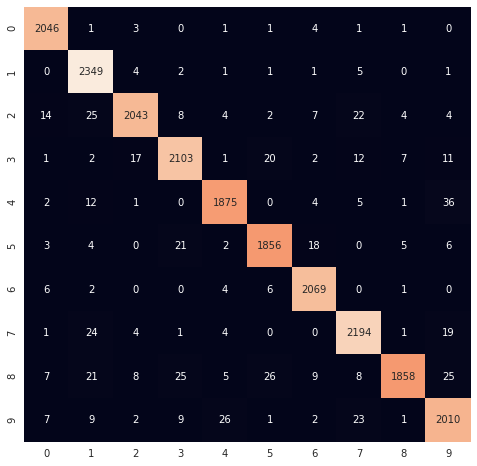

In [28]:
figure=plt.figure(figsize=(8,8))
g1=sns.heatmap(confusion_matrix(y_test, predictions), annot=True, fmt='d',cbar=False)